In [103]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import prepState
from numpy import linalg as LA
from timeEvo import *
#from generateStates import *
from qutip import *

# for using tex formatting and font in plots
#"""
plt.rcParams.update({"text.usetex": True,}) 
mpl.rcParams['text.latex.preamble'] = [r'\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{lmodern}\inputencoding{utf8}\usepackage{amsmath}\usepackage{amssymb}\usepackage{dsfont}\usepackage{mathtools}\usepackage{physics}']
mpl.rc('font', **{'family':'sans-serif', 'size':11})
cmap = mpl.cm.get_cmap('viridis')#['viridis', 'plasma', 'inferno', 'magma', 'cividis']
#"""

In [104]:
## a lot of functions
#
def generateStates(N, interaction):
    myStates = {}
    myBasis = {}
    for i in range(N+1):
        myStates["sigmaX", i] = prepState.stateX(N,i)
        myStates["sigmaY", i] = prepState.stateY(N,i)
        myStates["sigmaZ", i] = prepState.stateZ(N,i)
        myBasis["zero",i] = prepState.state0(N,i)
        myBasis["one",i] = prepState.state1(N,i)

    if interaction=="hom": #homogenous interaction strength. 
        Hint = 0
        for i in range(N): # interaction hamiltonian, XY-Heisenberg #l / 2 * np.sqrt((i+1)*(N-i))
            Hint = Hint + (myStates["sigmaX", i] * myStates["sigmaX", i+1] + myStates["sigmaY", i] * myStates["sigmaY", i+1])
        J = 1
        Hint = J * Hint # change interaction strength 

        H0 = 0
        for i in range(0,N+1):
                H0 = H0 - myStates["sigmaZ", i]
        Hges = Hint + H0
        return Hges
    elif interaction=="perf":
        Hint = 0
        l=1
        for i in range(N): # interaction hamiltonian, XY-Heisenberg #
            Hint = Hint + l / 2 * np.sqrt((i+1)*(N-i)) * (myStates["sigmaX", i] * myStates["sigmaX", i+1] + myStates["sigmaY", i] * myStates["sigmaY", i+1])
        J = 1/2
        Hint = J * Hint # change interaction strength

        H0 = 0
        for i in range(0,N+1):
                H0 = H0 - myStates["sigmaZ", i]
        Hges = Hint + H0
        return Hges


def generateRho(beta):
    rho = (-beta * sigmaz()).expm()
    Z = rho.tr()
    rho = rho/Z
    return rho


def timeEvo(dt, rho, Hint): # time evolution of an operator rho, SE approach as opposed to me approach
	U = (-1.j * Hint * dt).expm()
	Ud = (1.j * Hint * dt).expm()
	rho = rho * Ud
	return U * rho


def initSystem(alpha, firstState, secondState, N):
	astar = -alpha
	rhoSystem = tensor(firstState, secondState) + alpha * tensor(Qobj([[0,1],[0,0]]), Qobj([[0,0],[1,0]])) + astar * tensor(Qobj([[0,0],[1,0]]), Qobj([[0,1],[0,0]]))
	for i in range(1,N):
		rhoSystem = tensor(rhoSystem, Qobj([[0,0],[0,1]]))
	return rhoSystem


In [105]:
## integrate
#
def integrate(N, psi0, tlist, solver, interaction):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []

    for n in range(N+1):
        op_list = [si for m in range(N+1)]

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    # construct the hamiltonian
    H = generateStates(N, interaction)

    # energy splitting terms

    # interaction terms
    

    # collapse operators
    c_op_list = []


    # evolve and calculate expectation values
    if solver == "me":
        result = mesolve(H, psi0, tlist, c_op_list, sz_list)
    elif solver == "mc":
        ntraj = 250 
        result = mcsolve(H, psi0, tlist, c_op_list, sz_list, ntraj)
    return result.expect


In [106]:
## define constants
#
cm = 1/2.54
N=2
betaOne = 1/300
betaTwo = 1/300

#alpha = 1.j * .25 * 1/(np.cosh(beta))**2
#astar = -alpha
n = 3200
dt = 1e-3
t = np.linspace(0, n*dt, n)

In [107]:
## initiate States1/3000000
firstState = generateRho(betaOne)
secondState = generateRho(betaTwo)#Qobj([[0,0],[0,1]])]
alpha = 1j* 1/((-betaOne * sigmaz()).expm().tr()) * 1/((-betaTwo * sigmaz()).expm().tr()) * np.exp(-(betaOne + betaTwo)/2) #1j* 1/((-betaOne * sigmaz()).expm().tr()) * 1/((-betaTwo * sigmaz()).expm().tr()) * np.exp(-(betaOne + betaTwo)/2)
chi = alpha * tensor(Qobj([[0,1],[0,0]]), Qobj([[0,0],[1,0]])) - alpha * tensor(Qobj([[0,0],[1,0]]), Qobj([[0,1],[0,0]]))
test_state = tensor(firstState, secondState) + alpha * tensor(Qobj([[0,1],[0,0]]), Qobj([[0,0],[1,0]])) - alpha * tensor(Qobj([[0,0],[1,0]]), Qobj([[0,1],[0,0]]))
print(firstState, secondState, test_state)
#for i in range(100):
#    betaTwo = betaOne/(np.exp(.1*i))
#    secondState.append(generateRho(betaTwo))
#    alpha.append(1j* 1/((-betaOne * sigmaz()).expm().tr()) * 1/((-betaTwo * sigmaz()).expm().tr()) * np.exp(-(betaOne + betaTwo)/2))
##alpha = 1.j * .25 * 1/(np.cosh(beta))**2
#print(alpha)
#rhoSystem_array=np.array() #initSystem(alpha, firstState, secondState, N)
#for i in alpha:
#    j=0
#    while j<i:
#        rhoSystem_array[:,j] = 
#    rhoSystem_list.append(initSystem(alpha[i], firstState, secondState[i], N))
rhoSystem = initSystem(alpha, firstState, secondState, N)
##rhoSystempoint5 = initSystem(.5*alpha, firstState, secondState, N)
##rhoSystempoint1 = initSystem(.1*alpha, firstState, secondState, N)
rhoSystem_zero = initSystem(0, firstState, secondState, N)


H_hom = generateStates(N, "hom")
H_perf = generateStates(N, "perf")

#qResult = qutip.mesolve(Hint, initSystem, t, [], []).states # mesolve = master equation approach
#myResult = [timeEvo(dt, initSystem, Hint) for dt in t]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.49833334 0.        ]
 [0.         0.50166666]] Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.49833334 0.        ]
 [0.         0.50166666]] Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.24833612+0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.24999722+0.j         0.        +0.24916529j
  0.        +0.j        ]
 [0.        +0.j         0.        -0.24916529j 0.24999722+0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.25166944+0.j        ]]


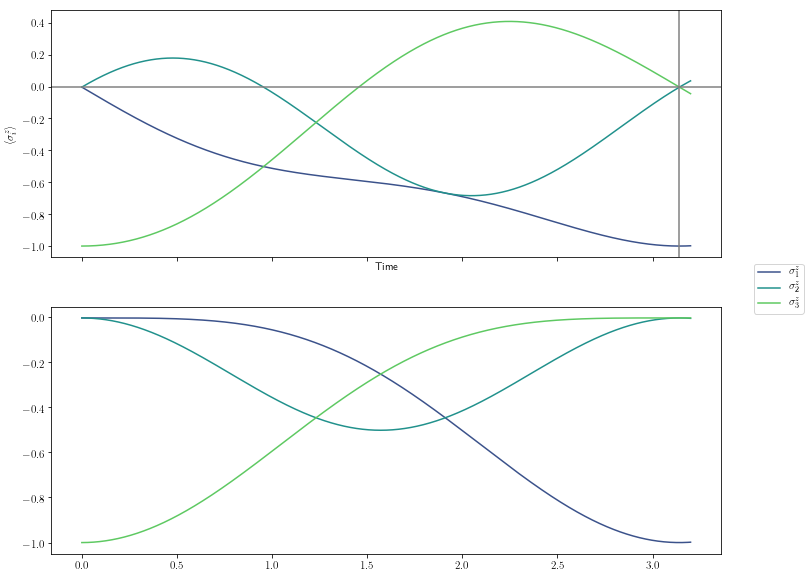

In [108]:
## veryfirstplotsxdd
#
sz = integrate(N, rhoSystem, t, "me", "perf")
sz0 = integrate(N, rhoSystem_zero, t, "me", "perf")

fig, (ax, ay) = plt.subplots(2, 1,sharex=True, figsize=(12,10))


for n in range(N+1):
    ax.plot(t, sz[n], label=r"$\sigma^z_{%d}$"%(n+1), color=cmap((n+1)/(N+2)))
    ay.plot(t, sz0[n], color=cmap((n+1)/(N+2)))
ax.set_xlabel(r'Time')
ax.set_ylabel(r'$\expval{\sigma^z_i}$')
ax.axvline(np.pi,color='grey')
ax.axhline(0,color='grey')
fig.legend(loc=7)
#fig.tight_layout()
#fig.subplots_adjust(right=0.8)
#extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#fig.savefig("alltheplots/j_const/expval_z.pdf")#, bbox_inches=(extent.expanded(4*cm, 4*cm)))

In [109]:
# calculate time evolution
#
perf_evo = qutip.mesolve(H_perf, rhoSystem, t, [], []).states
perf_evo_zero = qutip.mesolve(H_perf, rhoSystem_zero, t, [], []).states
hom_evo = qutip.mesolve(H_hom, rhoSystem, t, [], []).states
#"""
#maxEvo = qutip.mesolve(Hint, rhoSystem, t, [], []).states
#point5Evo = qutip.mesolve(Hint, rhoSystempoint5, t, [], []).states
#point1Evo = qutip.mesolve(Hint, rhoSystempoint1, t, [], []).states
#zeroEvo = qutip.mesolve(Hint, rhoSystemzero, t, [], []).states
#"""


In [110]:
### a shitton of quantities, the lists are always the values as a function of t
##
#
#myFidelity = [fidelity(firstState, myResult[i].ptrace(N).unit()) for i in range(0,n+1)]
#qEnt = [entropy_vn(timeEvo(dt, initSystem, Hint).ptrace(N), base=np.e) for dt in t]
#myInfoflow = np.diff(qEnt)/dt
#myHeatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(timeEvo(dt, initSystem, Hint), Hint).unit().ptrace(N) * sigmaz()).tr() for dt in t]
#myKLdiv = [entropy_relative(firstState.unit(), timeEvo(dt, initSystem, Hint).ptrace(N)) for dt in t]
#myHeatflow = [-1.j * (commutator(timeEvo(dt, initSystem, Hint), Hint).unit().ptrace(N) * sigmaz()).tr() for dt in t]
#myInfoflow2 = [myInfoflow[n]**2 for n in range(len(myInfoflow))]
### stuff that is new in main.py
##
#
#qEntmax = [entropy_vn(maxEvo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
#qEntpoint5 = [entropy_vn(point5Evo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
#qEntpoint1 = [entropy_vn(point1Evo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
#qEntzero = [entropy_vn(zeroEvo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
#print('#')
#infoFlowmax = np.square(np.diff(qEntmax)/t[1])
#infoFlowpoint5 = np.square(np.diff(qEntpoint5)/t[1])
#infoFlowpoint1 = np.square(np.diff(qEntpoint1)/t[1])
#infoFlowzero = np.square(np.diff(qEntzero)/t[1])
#print('##')
#maxHeatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(Hint, maxEvo[dt]).ptrace(N) * sigmaz()).tr() for dt in range(len(t))]
#point5Heatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(Hint, point5Evo[dt]).ptrace(N) * sigmaz()).tr() for dt in range(len(t))]
#point1Heatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(Hint, point1Evo[dt]).ptrace(N) * sigmaz()).tr() for dt in range(len(t))]
#zeroHeatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(Hint, zeroEvo[dt]).ptrace(N) * sigmaz()).tr() for dt in range(len(t))]
#print('###')
#maxFid = [fidelity(firstState, maxEvo[dt].ptrace(N)) for dt in range(len(t))]
#point5Fid = [fidelity(firstState, point5Evo[dt].ptrace(N)) for dt in range(len(t))]
#point1Fid = [fidelity(firstState, point1Evo[dt].ptrace(N)) for dt in range(len(t))]
#zeroFid = [fidelity(firstState, zeroEvo[dt].ptrace(N)) for dt in range(len(t))]
#print('####')
#magnet_max_first = [expect(maxEvo[dt].ptrace(0), sigmaz()) for dt in range(len(t))]
#magnet_max_last = [expect(maxEvo[dt].ptrace(N), sigmaz()) for dt in range(len(t))]
#magnet_zero_first = [expect(zeroEvo[dt].ptrace(0), sigmaz()) for dt in range(len(t))]
#magnet_zero_last = [expect(zeroEvo[dt].ptrace(N), sigmaz()) for dt in range(len(t))]
##magnet_point1 = [expect(point1Evo[dt].ptrace(N), sigmaz()) for dt in range(len(t))]
##magnet_zero = [expect(zeroEvo[dt].ptrace(N), sigmaz()) for dt in range(len(t))]
#"""

In [116]:
## quantities for perfect transfer
#

#fid_hom  = [fidelity(firstState, hom_evo[dt].ptrace(N)) for dt in range(len(t))][N-1,N]
fid_perf  = [fidelity(firstState, perf_evo[dt].ptrace(N)) for dt in range(len(t))]

#dkl_hom = [entropy_relative(firstState, hom_evo[dt].ptrace(N)) for dt in range(len(t))]
dkl_perf  = [entropy_relative(firstState, perf_evo[dt].ptrace(N)) for dt in range(len(t))]

#fid_hom  = [fidelity(firstState, hom_evo[dt].ptrace(N)) for dt in range(len(t))]
fid_perf_zero  = [fidelity(firstState, perf_evo_zero[dt].ptrace(N)) for dt in range(len(t))]

#dkl_hom = [entropy_relative(firstState, hom_evo[dt].ptrace(N)) for dt in range(len(t))]
dkl_perf_zero  = [entropy_relative(firstState, perf_evo_zero[dt].ptrace(N)) for dt in range(len(t))]


#qEnt_hom = [entropy_vn(hom_evo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
#infoFlow_hom = np.square(np.diff(qEnt_hom)/dt)
#Heatlim_hom = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(H_hom, hom_evo[dt]).ptrace(N) * sigmaz()).tr() for dt in range(len(t))]tensor(sigmaz(), qeye(2))+tensor(qeye(2), sigmaz())

qEnt_perf = [entropy_vn(perf_evo[dt].ptrace(N), base=np.e) for dt in range(len(t))]
infoFlow_perf = np.square(np.diff(qEnt_perf)/dt)
Heatlim_perf = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(H_perf, perf_evo[dt]).ptrace(N) * (sigmaz())).tr() for dt in range(len(t))]

qEnt_perf_zero = [entropy_vn(perf_evo_zero[dt].ptrace(N), base=np.e) for dt in range(len(t))]
infoFlow_perf_zero = np.square(np.diff(qEnt_perf_zero)/dt)
Heatlim_perf_zero = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(H_perf, perf_evo_zero[dt]).ptrace(N) * sigmaz()).tr() for dt in range(len(t))]

diff = [-Heatlim_perf_zero[dt] + Heatlim_perf[dt] for dt in range(len(t))]

#test = [i for i in fid_perf if i>=.9999]
#print(test)
#print(fid_hom)

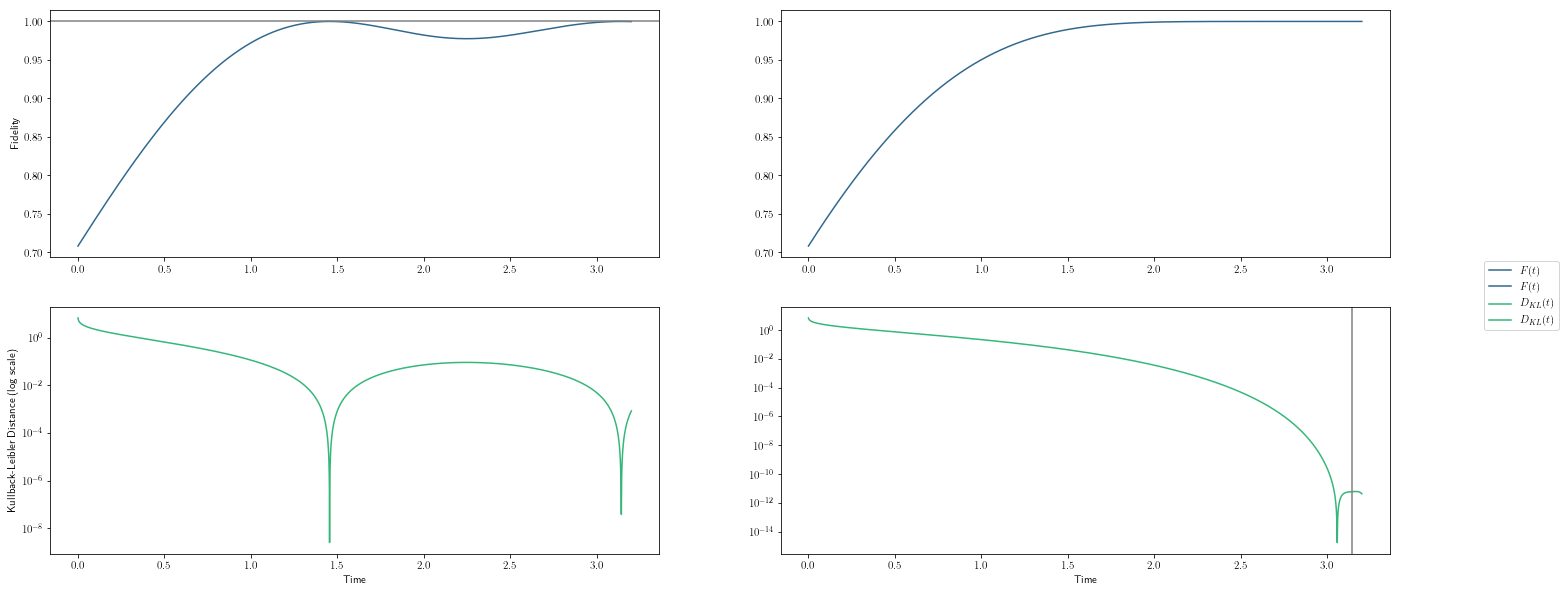

In [112]:
fig, ((ax, ax0), (ax1, ax2)) = plt.subplots(2,2,figsize=(24,10))


ax.plot(t, fid_perf, label=r"$F(t)$", color=cmap(1/3))
ax0.plot(t, fid_perf_zero, label=r"$F(t)$", color=cmap(1/3))
ax1.plot(t, dkl_perf, label=r"$D_{KL}(t)$", color=cmap(2/3))
ax1.set_yscale('log')
ax1.set_xlabel(r'Time')
ax2.plot(t, dkl_perf_zero, label=r"$D_{KL}(t)$", color=cmap(2/3))
ax2.set_yscale('log')
ax2.set_xlabel(r'Time')
ax.set_ylabel(r'Fidelity')
ax1.set_ylabel(r'Kullback-Leibler Distance (log scale)')
#ax.set_yscale('log')
#ax.axvline(np.pi,color='grey')
ax2.axvline(np.pi,color='grey')
ax.axhline(1,color='grey')
fig.legend(loc=7)
#fig.tight_layout()
fig.subplots_adjust(right=0.9)
#plt.savefig("alltheplots/j_const/fidelity.pdf")

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


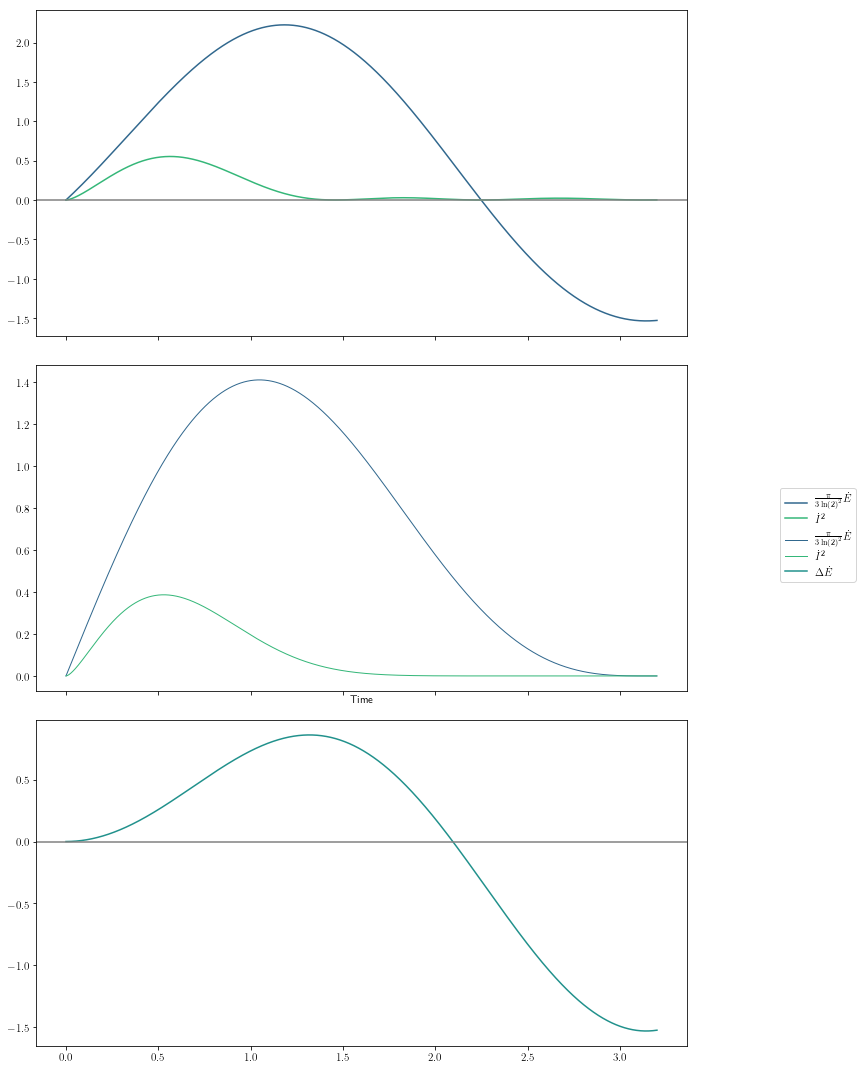

In [118]:
fig, (axs1, axs2, axs3)= plt.subplots(3, 1, sharex=True, figsize=(12,15))

#(np.pi/3 *1 / (np.log(2)**2))
axs1.plot(t, Heatlim_perf, label=r"$\frac{\pi}{3\ln(2)^2}\dot{E}$", color=cmap(1/3))
axs1.plot(t[:-1], infoFlow_perf, label=r"$\dot{I}^2$", color=cmap(2/3))
axs1.axhline(0, color="grey")
#axs1.set_xlabel(r"Time")
axs2.plot(t, Heatlim_perf_zero, label=r"$\frac{\pi}{3\ln(2)^2}\dot{E}$", color=cmap(1/3), linewidth=1)
axs2.plot(t[:-1], infoFlow_perf_zero, label=r"$\dot{I}^2$", color=cmap(2/3), linewidth=2*.5)
axs3.plot(t, diff, label=r"$\Delta \dot{E}$", color = cmap(.5))
axs3.axhline(0, color="grey")
#axs2.axhline(0, color="grey")
axs2.set_xlabel(r"Time")
#axs2.set_xlim(2,3.2)
#axs1.set_ylabel(r"Squared information flow and its bound")
#axs1.annotate(r"first 1", xy=(0.9,1), xytext=(0.8,0.95), arrowprops=dict(arrowstyle='->', facecolor='black'))
#axs1.text(0,0.96,r"a)")
#axs1.set_title(r"nicer plot", loc="right")
fig.tight_layout()
fig.legend(loc=7)

fig.subplots_adjust(right=.8)

plt.savefig("alltheplots/j_var/pendrytest.pdf")
#plt.show()